# Cloud Types Determination by Altitude for Analyzing Cloud Radiative Effects

Production date: 23-10-2024

Produced by: CNRS

## 🌍 Use case: Intercomparison of cloud top altitude distributions from satellite retrievals

## ❓ Quality assessment question:
 - __How does cloud top pressure vary between climate zones, and which dataset provides the most realistic distribution?__



Clouds are fundamental regulators of the Earth's climate system, significantly influencing the planet's radiative budget, hydrological cycle, and global circulation. These factors, in turn, play a crucial role in shaping ecosystems, agriculture, water resources, and weather patterns. The overall impact of clouds on Earth's climate is determined by various properties, including cloud height, amount, thickness, and microphysical characteristics. Given their substantial influence on climate, cloud properties are extensively studied, both in the present context and in relation to their evolution under climate change.
The following notebook focuses on the cloud height.

High and low clouds have distinct atmospheric radiative effects due to differences in temperature, thickness, and composition. High clouds strongly trap outgoing longwave infrared radiation from the Earth’s surface, and they allow most shortwave solar radiation to pass when they are thin. This leads to a net warming effect on both the surface and the atmosphere. In contrast, low clouds reflect a significant portion of incoming solar radiation back into space, producing a cooling effect.

This analysis utilizes cloud observations from the dataset [__Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations__](https://cds-beta.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview), derived from satellite observations and available through the Climate Data Store. The cloud properties in this dataset are provided by three distinct products, categorized into two main families.
The CLARA (CM SAF cLoud, Albedo and surface Radiation) product family includes two retrieval versions applied on AVHRR (Advanced Very High Resolution Radiometer) observations, CLARA-A2 and CLARA-A3. The CCI (Climate Change Initiative) product family is represented by a single product derived from ATSR (Along Track Scanning Radiometer) and SLSTR (Sea and Land Surface Temperature Radiometer). 


The three datasets, CLARA-A2, CLARA-A3, and CCI, use distinct methods to retrieve cloud properties. This notebook presents a comparative analysis of the cloud top pressure estimates from these datasets, both among themselves and against other satellite data [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). The three datasets also provide information on cloud top temperature and altitude. However, this analysis focuses on cloud-top pressure, as it is more closely related to the radiative transfer processes. In order to transform one to the other, atmospheric profiles are used, often obtained from meteorological reanalyses.




## 📢 Quality assessment statement 

It is important to note that passive remote sensing has limitations: it provides a top-down perspective, which does not account for hidden cloud layers, and it estimates the 'radiative' cloud height. This radiative height can be several kilometers below the actual cloud top, especially in cases where clouds have diffuse tops, with optical depth gradually increasing from the top down over a significant vertical range. This phenomenon is particularly relevant for approximately 70% of high clouds in the tropics and 30-40% of high clouds in the midlatitudes [[2]](https://doi.org/10.1029/94JD02430).

```{admonition} These are the key outcomes of this assessment

- All datasets show more low-level clouds over ocean than over land, as expected.

- The CCI dataset produces by far the least realistic cloud distributions among the evaluated products, by strongly underestimating the amount of high-level clouds (no peak in the upper troposphere). Since the channels of the AATSR and AVHRR instruments are similar, the reason lies in the retrieval method, based on optimal estimation and the assumption of a single layer cloud. The simultaneous use of infrared and visible radiances leads in the case of semi-transparent cirrus above lower cloud layers to a cloud height underestimation.

- The two retrieval versions of the same product CLARA give very different results. While the A2 version uses a classical retrieval approach, based on radiative transfer, the A3 version uses a neural network approach trained with active lidar data from CALIPSO. This leads to retrievals of ‘radiative’ cloud height for CLARA-A2 and cloud top height for CLARA-A3. Furthermore, the CLARA-A3 product also include very thin (sub-visible) cirrus clouds above the tropopause layer, which a passive sensor like AVHRR is not able to detect, in particular stratospheric clouds in polar regions during winter.

- The CLARA-A2 cloud top pressure of high clouds peaks in the tropics at about 250 hPa. At higher latitudes over ocean, CLARA-A2 shows a much smaller contribution of high clouds, while over land high clouds have a similar contribution as in the tropics, but their height decreases, following the tropopause. The height of low-level clouds over ocean may be slightly overestimated (800 instead of 850 hPa).

- Over ocean, the CLARA-A3 cloud top pressures show similar, but narrower peaks around 800 hPa, while in the upper troposphere the peaks are much more pronounced and at a much higher altitude (150 hPa to 220 hPa) than CLARA-A2. Furthermore, pronounced peaks above the tropopause appear at higher latitudes which correspond to very thin, stratospheric clouds in the winter. Over land, the distributions show a single broader peak close to the tropopause.

- CCI daytime observations of cloud top pressure exhibit unacceptably large uncertainty estimates, while CCI nighttime observations tend to show unusually small uncertainty estimates over land.

- While CLARA-A2 does not provide uncertainty estimates, the uncertainty distributions of CLARA-A3 peak around 20 hPa over the whole globe, with broader distributions for low-level clouds than for high-level clouds and a secondary peak around 100 hPa over land, which is due to gridboxes with only a fewer cloudy observations.

```



## 📋 Methodology


The analysis comprises the following steps:

**[](section:parameters)**
 * Import the relevant libraries. Define the parameters of the analysis and set the dataset requests.

**[](section:download)**
 * Download the three daily satellite products of cloud top pressure.
 * Filter out days with low-quality status for CLARA-A3.


**[](section:results)**
 * Standardize the datasets into a uniform format and organize them within a single dictionary
 * Include the land mask into the datasets
 * Plot the cloud pressure distributions for each selected region of interest
 * Plot the cloud pressure uncertainty distribution for the daytime observation of the CCI product
 * Plot the cloud pressure uncertainty distribution for each selected region of interest for CLARA-A3 and CCI nighttime observations

## 📈 Analysis and results

(section:parameters)=
### Choose the parameters to use and setup code

This section includes the library imports and the parameter settings for the analysis.

#### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import dask.array as da
import numpy as np
import regionmask
from c3s_eqc_automatic_quality_control import download, plot
import warnings
import cartopy.crs as ccrs

# Suppress all warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-notebook")

import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/mandorli_giulio/.cdsapirc")

#### Define parameters

In [2]:
# Time
start = "2011-01"
stop = "2011-12"

# Datasets and associated colors
colors = {
    'CCI day'      : 'dodgerblue',
    'CCI night'    : 'darkblue',
    'CLARA-A2' : 'orange',
    'CLARA-A3' : 'red',
}

styles = {
    'CCI day'      : '--',
    'CCI night'    : ':',
    'CLARA-A2' : '-',
    'CLARA-A3' : '-',
}

# regions
latitude_band = {
    'deep-tropics' :  {'from': 0,  'to': 10},
    'sub-tropics' :   {'from': 10, 'to': 30},
    'mid-latitudes' : {'from': 30, 'to': 60},
    'polar' :         {'from': 60, 'to': 80},
}
    

#### Set the data request

In [3]:
collection_id = 'satellite-cloud-properties'

chunks = {"year": 1, "month": 1}

def preprocess(ds):
    time = pd.to_datetime(ds.attrs["time_coverage_start"])
    return ds.assign_coords(time=np.array([time], dtype='datetime64[ns]') )

request_cci =  {
        'product_family': 'cci',
        'time_aggregation': 'daily_mean',
        'climate_data_record_type': 'thematic_climate_data_record',
        'sensor_on_satellite': 'aatsr_on_envisat',
        'variable': 'all_variables',
        'origin': 'esa',
        }

request_clara =  {
    'origin': 'eumetsat',
    'variable': ['cloud_top_level'],
    'climate_data_record_type': 'thematic_climate_data_record',
    'time_aggregation': 'daily_mean',
    }

request_clara_a2 = request_clara | {'product_family': 'clara_a2'}
request_clara_a3 = request_clara | {'product_family': 'clara_a3'}


(section:download)=
### Download the datasets

In this section, three datasets are downloaded. The CCI files lack "time" information within the xarray coordinates; therefore, the time information is extracted from the file attributes.

In addition, the CLARA-A3 product provides a quality flag labeled "record_status" which indicates the overall status of each day. This flag indicates the quality of the data, and any day identified as low quality is subsequently filtered out.

In [4]:
ds_cci = download.download_and_transform(
    collection_id,
    download.update_request_date(request_cci, start, stop, stringify_dates=True),
    chunks=chunks,
    preprocess=preprocess,
)

100%|██████████| 12/12 [00:01<00:00, 11.56it/s]


In [5]:
ds_clara_a2 = download.download_and_transform(
    collection_id,
    download.update_request_date(request_clara_a2, start, stop, stringify_dates=True),
    chunks=chunks,
)

100%|██████████| 12/12 [00:01<00:00, 11.55it/s]


In [6]:
ds_clara_a3 = download.download_and_transform(
    collection_id,
    download.update_request_date(request_clara_a3, start, stop, stringify_dates=True),
    chunks=chunks,
)

100%|██████████| 12/12 [00:00<00:00, 15.02it/s]


#### Filter out CLARA-A3 low-quality status

For the CLARA-A3 product, the "record_status" for each day can have the following values: 0 for "ok", 1 for "void", and 2 for "bad_quality". Records marked with "bad_quality" must be filtered out; however, all days have good quality in the selected period.

In [7]:
value_counts = ds_clara_a3.record_status.to_pandas().value_counts() 

for status in [0,1,2] :
    print(f'Number of records with status {status}: ', value_counts.get(status, 0))

# Filter-out low quality data
ds_clara_a3 = ds_clara_a3.where(ds_clara_a3['record_status'].compute() == 0, drop=True)

Number of records with status 0:  365
Number of records with status 1:  0
Number of records with status 2:  0


_Number of records for each status: 0 for "ok", 1 for "void", and 2 for "bad_quality"._

(section:results)=
### Results

In this section, the cloud top pressure and the associated uncertainty estimates are shown.

In order to ensure consistency across the datasets, all three datasets are initially standardized to a uniform format. The cloud data is then categorized into land and ocean records. Finally, a custom function, "plot_cloud_top_distribution", is created to visualize the distribution of cloud top pressure across various regions.

The last subsection addresses the uncertainty in cloud top pressure estimates. It begins by presenting the distribution of daytime CCI observations. A custom function, "plot_uncertainties", is then introduced to visualize the uncertainty distribution for the remaining datasets.


#### Standardize the different datasets into the same format

In [8]:
DS_dict = {'CCI day'  : ds_cci[['ctp_day', 'ctp_day_cor']],
           'CCI night': ds_cci[['ctp_night', 'ctp_night_cor']],
           'CLARA-A2' : ds_clara_a2[['ctp']],
           'CLARA-A3' : ds_clara_a3[['ctp', 'ctp_unc01']],
          }

DS_dict['CCI day']   = DS_dict['CCI day'].rename({'ctp_day' : 'ctp', 'ctp_day_cor' : 'ctp_unc'})
DS_dict['CCI night'] = DS_dict['CCI night'].rename({'ctp_night' : 'ctp', 'ctp_night_cor' : 'ctp_unc'})
DS_dict['CLARA-A3']  = DS_dict['CLARA-A3'].rename({'ctp_unc01' : 'ctp_unc'})


land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110

for dataset_name, ds_ in DS_dict.items():

    land_mask = land_110.mask_3D(ds_).squeeze("region", drop=True)
    DS_dict[dataset_name]['land_mask']    = land_mask 


In [9]:
DS_dict_land = dict()
DS_dict_sea  = dict()


for dataset_name, ds_ in DS_dict.items() :
    DS_dict_land[dataset_name] = DS_dict[dataset_name].where(DS_dict[dataset_name]['land_mask'])
    DS_dict_sea[dataset_name]  = DS_dict[dataset_name].where(~DS_dict[dataset_name]['land_mask'])


#### Cloud top pressure 

In [10]:
tropopause_level = {
    'deep-tropics' :  {'level': 100,  'width': 10},
    'sub-tropics' :   {'level': 100,  'width': 10},
    'mid-latitudes' : {'level': 200,  'width': 50},
    'polar' :         {'level': 250,  'width': 40},
}
    
def plot_cloud_top_distribution (DSs, label = 'land') : 
    
    N = len(latitude_band.keys())
    fig, axs = plt.subplots(1, N , figsize=(14, 5), sharey=True)
    
    
    for n, lat_band_name in enumerate(latitude_band.keys()) :

        lat_band = latitude_band[lat_band_name]
        lat_from = lat_band['from']
        lat_to   = lat_band['to']
        
        for dataset_name, ds_ in DSs.items() :
            #print(lat_band, dataset_name, lat_from, lat_to)
    
            ds_tmp = ds_.where(((ds_.latitude >= lat_from) & (ds_.latitude < lat_to)) |
                               ((ds_.latitude > -lat_to) & (ds_.latitude < lat_from)),
                               drop=True)

            
            # Access the underlying Dask array
            dask_arr = ds_tmp.ctp.data

            n_bins = 50
            hist_dask, bin_edges_dask = da.histogram(dask_arr, bins=n_bins, range=[0,1000])
            h, bin_edges = da.compute(hist_dask, bin_edges_dask)
            h  = h /np.sum(h) * n_bins / 10. # normalization
            
            x_values = (bin_edges[1:]+bin_edges[:-1])/2.
            ax=axs[n]
            ax.plot(h, x_values, color=colors[dataset_name], ls=styles[dataset_name], label=dataset_name)
            ax.set_xlabel('Normalized Density [hPa$^{-1}$]')
            ax.set_title(lat_band_name)
            ax.text(0.8, 0.96, label, transform=ax.transAxes, fontsize=12, weight='bold', ha='center', va='center')

            
        ax.fill_between(ax.get_xlim(),
                (tropopause_level[lat_band_name]['level'] - tropopause_level[lat_band_name]['width'])*np.ones(2),
                (tropopause_level[lat_band_name]['level'] + tropopause_level[lat_band_name]['width'])*np.ones(2),
                color='gray', alpha=0.5)
                
    
    axs[0].legend()
    axs[0].set_ylabel('Cloud Top Pressure [hPa]')
    axs[0].invert_yaxis()

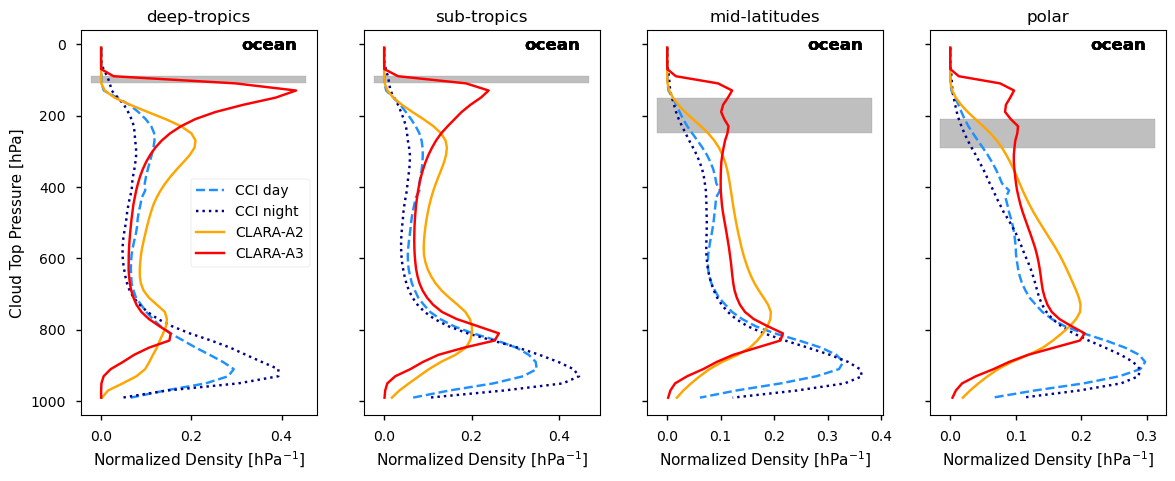

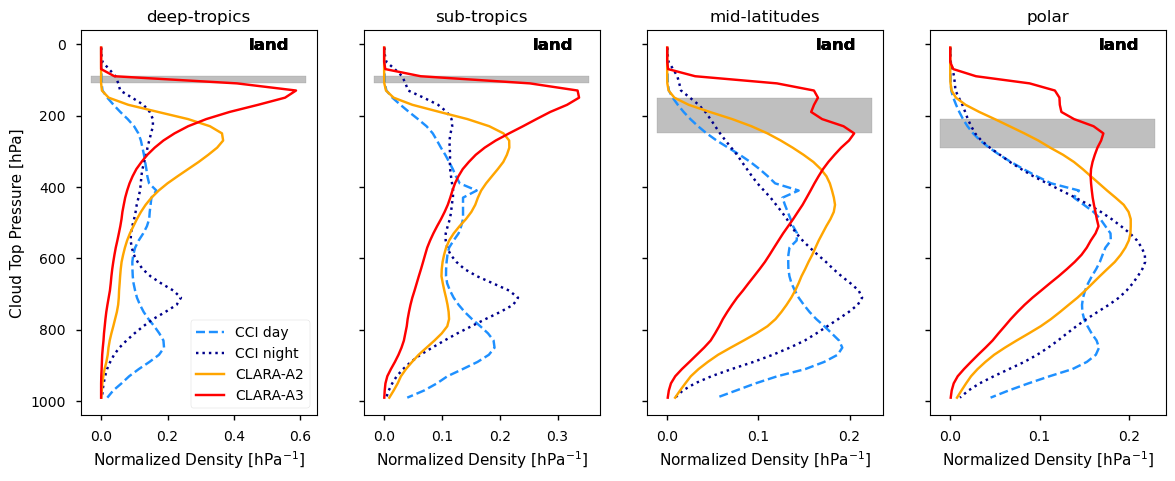

In [11]:
plot_cloud_top_distribution(DS_dict_sea,  label='ocean')
plot_cloud_top_distribution(DS_dict_land, label='land')

_**Figure caption:** Cloud top pressure distributions over ocean (top) and land (bottom) separately for deep-tropics, sub-tropics, mid-latitude, and polar regions during the period of interest. The blue lines show the CCI dataset, while the orange and red lines show CLARA-A2 and CLARA-A3 respectively. Tropopause levels (depending on season) are shown in gray. The tropopause shifts from about 100 hPa (~17 km) in the tropics to 250 hPa (~9 km) in the polar regions._

The cloud top pressure distributions are presented for the CCI, CLARA-A2, and CLARA-A3 datasets. These normalized distributions provide a view from above, without accounting for hidden cloud layers beneath the top layer. While several features are consistent across the three datasets, others show notable differences. In the following, these distributions are compared with the results from the GEWEX cloud assessment [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0) to estimate which dataset offers the most realistic representation.

The GEWEX cloud assessment indicates that cloud top pressure distributions over oceans exhibit a bimodal pattern in tropical regions, with pronounced peaks in the upper and lower troposphere. These strong peaks decrease in intensity as one moves toward the polar regions. Over land, the contribution of single-layer low-level clouds is minimal. Moreover, the cloud tops of high clouds are high in the tropics and gradually lower toward the poles following the tropopause.

The CLARA-A2 dataset correctly captures two distinct peaks in cloud density over tropical oceans, corresponding to high and low cloud layers. These peaks converge into the mid-troposphere as they approach polar regions. Over land, the cloud density peaks at high altitudes in the tropics, with this peak becoming broader and shifting to lower altitudes toward the poles. The updated GEWEX cloud assessment includes several cloud datasets
provided by the Cloud-Aerosol Lidar and Infrared Pathfinder Satellite Observation (CALIPSO) Science Team [[5]](https://doi.org/10.5194/amt-12-703-2019) one mimicking the sensitivity of passive remote sensing [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). With respect to this dataset(CALIPSO-passive), the height of low-level clouds given by CLARA-A2 is slightly overestimated (800 instead of 850 hPa), while the height of high-level clouds is underestimated. The latter is expected, since the active
lidar of CALIPSO determines the cloud top, while a classical cloud retrieval using (passive) radiometers, yields a 'radiative' cloud height, which is below the cloud top, in particular for diffuse cloud tops which are frequent in the tropics [[2]](https://doi.org/10.1029/94JD02430). It should be noted that the CLARA-A2 version displayed in [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0) is an earlier version than the one provided in the CDS (versions 2.0 and 2.1, respectively).

The CLARA-A3 dataset also depicts two distinct peaks in cloud density over tropical oceans, associated with high and low clouds. These peaks are more narrow and pronounced, particularly in the high troposphere. Over land, CLARA-A3 shows a significant peak of high clouds in the tropics, which becomes less prominent at polar latitudes as the mid-level cloud presence increases. The cloud top pressure retrieval for CLARA-A3 is based on a neural network trained on CALIPSO cloud data. Consequently, the CLARA-A3 product also includes very thin (sub-visible) cirrus clouds in the tropopause layer, which a passive sensor like AVHRR is not able to detect, in particular stratospheric clouds in polar regions during winter. Compared to CALIPSO results in [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0), low-level clouds over ocean have slightly higher cloud tops (800 instead of 850 hPa), as CLARA-A2, but the peaks are narrower than for CLARA-A2.

The CCI product only provides cloud top pressure data separately for daytime and nighttime. Both provide similar distributions over ocean, but cloud altitudes are shifted downwards during daytime. Furthermore, the distributions of cloud top pressure differ significantly from those in the CLARA product family and those deduced from similar instruments as shown in Figure 6 of [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). The CCI product overestimates the relative occurrence of low clouds and strongly underestimates the relative occurrence of high clouds, both over land and ocean, especially over tropical and mid-latitude regions. In particular, the expected high-altitude peak in the tropics is nearly negligible. Overall, these cloud top pressure distributions are the least realistic among the products evaluated.



#### Cloud top pressure uncertainty 

In this subsection, the uncertainty estimates for cloud top pressure across the available datasets are presented. It is important to note that the CLARA-A2 cloud top pressure retrieval does not provide any uncertainty estimates. Therefore, this product will not be included in the following discussion.

The CCI dataset provides cloud top pressure and its associated uncertainty separately for daytime and nighttime. Its uncertainty for daytime observations is presented first, followed by CLARA-A3 and CCI nighttime observations.

Text(0, 0.5, 'Density [hPa$^{-1}$]')

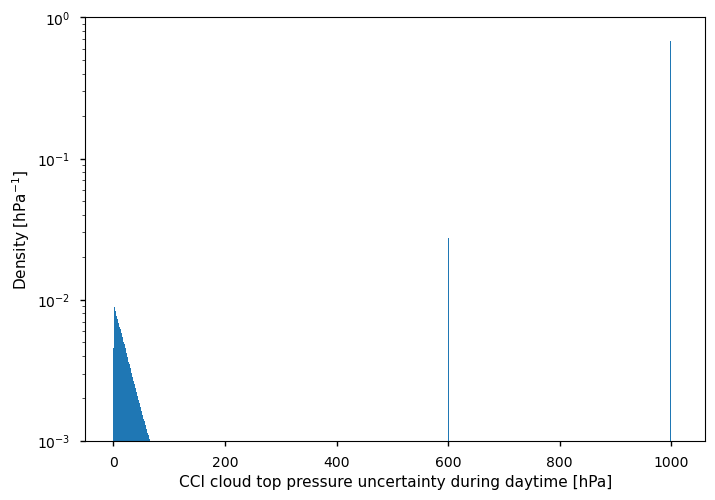

In [12]:
CCI_unc_day = ds_cci.ctp_day_cor.data.flatten().compute()

plt.hist(CCI_unc_day[~np.isnan(CCI_unc_day)], density=True, range=[0,1010], bins=1010)

plt.ylim(0.001, 1)
plt.yscale('log')
plt.xlabel('CCI cloud top pressure uncertainty during daytime [hPa]')
plt.ylabel('Density [hPa$^{-1}$]')

_**Figure caption:** Distribution of cloud top pressure uncertainty during daytime provided by the CCI product._

The distribution of daytime cloud top pressure uncertainty is very surprising for a publicly distributed dataset. Only a small fraction of the values fall within an acceptable range, with a peak around 20 hPa. The majority of the values are either 600 hPa or 1000 hPa. This  is observed across all regions, both over ocean and land (not shown). Therefore, users are advised to use these data with caution.

In [13]:
def plot_uncertainties (DSs, label_region='land', label_height='low clouds') :

    N = len(latitude_band.keys())
    fig, axs = plt.subplots(1, N , figsize=(14, 3.5), sharey=True)
    
    
    for n, lat_band_name in enumerate(latitude_band.keys()) :

        lat_band = latitude_band[lat_band_name]
        lat_from = lat_band['from']
        lat_to   = lat_band['to']
        
        for dataset_name, ds_ in DSs.items() :
            if dataset_name in ['CLARA-A2', 'CCI day'] : continue

            ds_tmp = ds_.where(((ds_.latitude >= lat_from) & (ds_.latitude < lat_to)) |
                                   ((ds_.latitude > -lat_to) & (ds_.latitude < lat_from)),
                                   drop=True)


            # Access the underlying Dask array
            ctp_unc_arr = ds_tmp.ctp_unc.data
            ctp_arr     = ds_tmp.ctp.data

            
            condition_cloud_level = (ctp_arr > 700) if label_height=='low clouds' else (ctp_arr < 200)
            ctp_unc_arr = np.where(condition_cloud_level, ctp_unc_arr, np.nan) 
            
            
            n_bins = 50
            hist_dask, bin_edges_dask = da.histogram(ctp_unc_arr, bins=n_bins, range=[0,150])
            h, bin_edges = da.compute(hist_dask, bin_edges_dask)
            h  = h /np.sum(h) * 100 # normalization
            
            x_values = (bin_edges[1:]+bin_edges[:-1])/2.
            ax=axs[n]
            ax.plot(x_values, h, color=colors[dataset_name], ls=styles[dataset_name], label=dataset_name )
            ax.set_xlabel('Cloud top pressure uncertainty')
            #ax.set_ylabel('Density [%]')
            ax.set_title(lat_band_name)
            ax.text(0.82, 0.88, label_region, transform=ax.transAxes, fontsize=12, weight='bold', ha='center', va='center')
            ax.text(0.78, 0.96, label_height, transform=ax.transAxes, fontsize=12, color='b', ha='center', va='center')
                
    axs[0].set_ylabel('Density [%]')
    axs[0].legend()



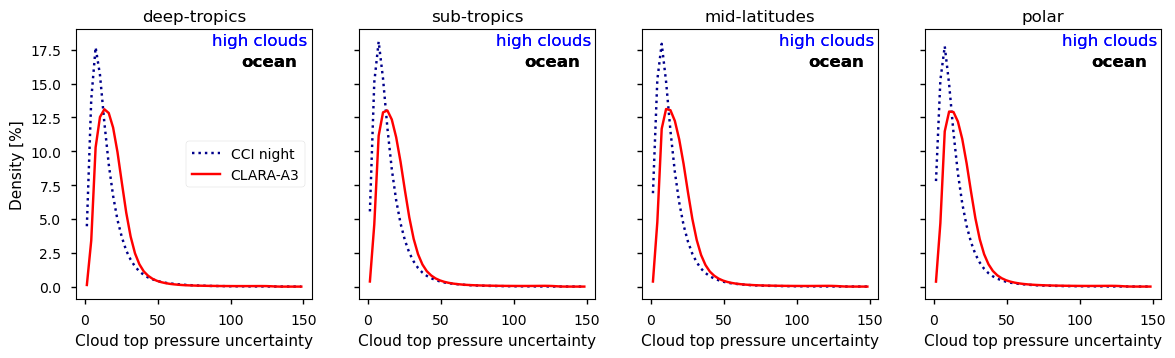

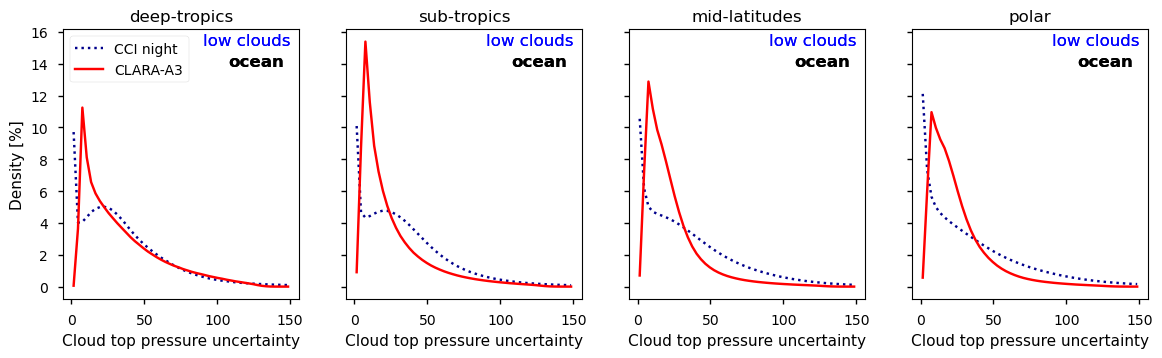

In [14]:
plot_uncertainties(DS_dict_sea,  label_region='ocean', label_height='high clouds')
plot_uncertainties(DS_dict_sea,  label_region='ocean', label_height='low clouds')

_**Figure caption:** Distribution of cloud top pressure uncertainty over ocean for high (top) and low clouds (bottom), in the deep tropics, subtropics, mid-latitudes, and polar regions during the period of interest. The red line represents the CLARA-A3 dataset, while the blue dotted lines indicate CCI nighttime data, respectively, from the CCI dataset._

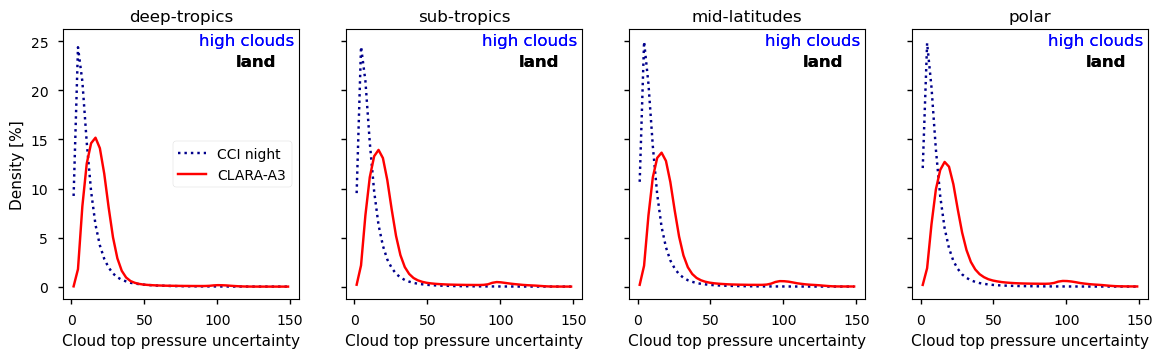

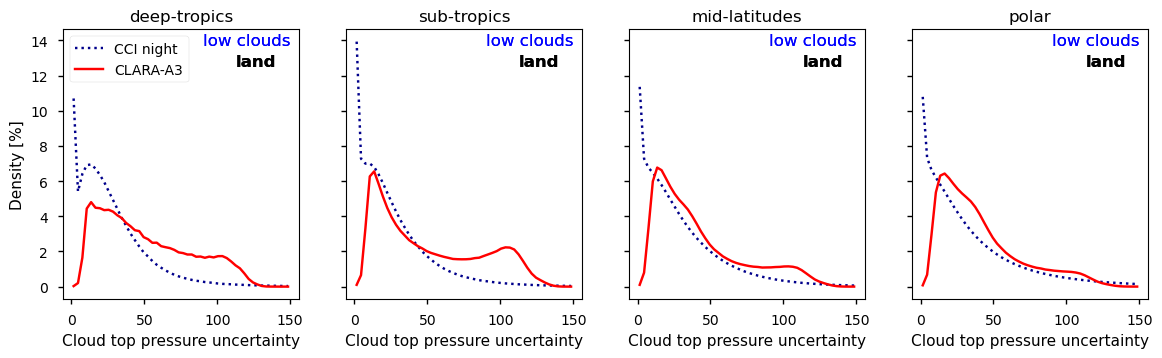

In [15]:
plot_uncertainties(DS_dict_land,  label_region='land', label_height='high clouds')
plot_uncertainties(DS_dict_land,  label_region='land', label_height='low clouds')

_**Figure caption:** Distribution of cloud top pressure uncertainty over land for high (top) and low clouds (bottom), in the by deep tropics, subtropics, mid-latitudes, and polar regions during the period of interest. The red line represents the CLARA-A3 dataset, while the light blue dotted lines indicate CCI nighttime data._

In the CLARA-A3 dataset, the distributions of cloud top pressure uncertainty starts at zero and peak around 20-30 hPa. Over the ocean, uncertainties above 50 hPa are negligible. However, over land, a secondary peak occurs around 100 hPa, which is attributed to gridboxes with only a few cloudy observations (not shown).

The CCI cloud top pressure uncertainty distributions display more variability across different categories. The uncertainty distributions for high clouds peak around 10-20 hPa, and then decrease sharply with increasing uncertainty. In contrast, the uncertainty distributions for low clouds show a significant peak at zero, indicating an underestimation of cloud top uncertainty. This is primarily due to clouds located closer to the surface.

## ℹ️ If you want to know more
### Key resources
Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used is:
- Cloud properties global gridded monthly and daily data from 1979 to present derived from satellite observations:
https://cds-beta.climate.copernicus.eu/datasets/satellite-cloud-properties?tab=overview

Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)


The GEWEX Cloud Assessment:
- The Global Energy and Water Exchanges (GEWEX) program is a core project of the World Climate Research Programme (WCRP). The first GEWEX Cloud Assessment was published in 2012 and it provided the first coordinated inter-comparison of publicly available, global
cloud products [[3](https://doi.org/10.1175/BAMS-D-12-00117.1)-[4](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf)]. The database associated with the GEWEX Cloud Assessment
has revealed its usefulness for the assessment of new datasets. Since in the last decade existing
cloud property retrievals have been revised and new retrievals have been developed, this exercise has been recently repeated with 11 global cloud products derived from measurements of multi-spectral imagers, IR sounders, and lidar [[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0). The first cloud assessment included products from ATSR, while the most recent assessment includes CLARA-A2. However, the CLARA-A2 version (V2.1) in the CDS is a later, improved version compared to the one provided in the updated GEWEX cloud assessment (V2.0). The updated cloud assessment database is available at [this link](https://gewexca.aeris-data.fr/).

### Reference/Useful material

[[1]](https://link.springer.com/article/10.1007/s10712-024-09824-0) Stubenrauch, C.J., Kinne, S., Mandorli, G. et al. Lessons Learned from the Updated GEWEX Cloud Assessment Database. Surv Geophys (2024). https://doi.org/10.1007/s10712-024-09824-0

[[2]](https://doi.org/10.1029/94JD02430) Liao, X., W. B. Rossow, and D. Rind (1995), Comparison between SAGE II and ISCCP high-level clouds: 2. Locating cloud tops, J. Geophys. Res., 100(D1), 1137–1147, doi:10.1029/94JD02430. 

[[3]](https://doi.org/10.1175/BAMS-D-12-00117.1) Stubenrauch, C. J., and Coauthors, 2013: Assessment of Global Cloud Datasets from Satellites: Project and Database Initiated by the GEWEX Radiation Panel. Bull. Amer. Meteor. Soc., 94, 1031–1049, https://doi.org/10.1175/BAMS-D-12-00117.1. 

[[4]](https://www.wcrp-climate.org/documents/GEWEX_Cloud_Assessment_2012.pdf) Stubenrauch CJ, Rossow WB, Kinne S, GEWEX Cloud Assessment Team (2012) Assessment of Global Cloud Datasets from Satellites, A Project of the World Climate Research Programme Global Energy and Water Cycle Experiment (GEWEX) Radiation Panel, WCRP report.

[[5]](https://doi.org/10.5194/amt-12-703-2019) Liu Z, Kar J, Zeng S, Tackett J, Vaughan M, Avery M, Pelon J, Getzewich B, Lee K-P, Magill B, Omar A, Lucker P, Trepte C, Winker D (2019) Discriminating between clouds and aerosols in the CALIOP version 4.1 data products. Atmos Meas Tech 12:703–734. https://doi.org/10.5194/amt-12-703-2019